In [1]:
import tensorflow as tf
import ddsp

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io.wavfile import read as wavread

import librosa
import librosa.display
import IPython.display as ipd

tf.executing_eagerly()

True

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
import os
import pathlib
from PIL import Image



from IPython import display

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [4]:
import scipy.fftpack as fft

def getS1andSignal(SNR_dB = None, signal1 = None):
    # frequency
    f1 = 1000.0
    Fs = 16000.0  # sampling frequency

    # Desired SNR in dB
    SNR_dB = SNR_dB

    # Desired linear SNR
    snr = 10.0**(SNR_dB/10.0)

    # Measure power of signal
    p1 = signal1.var()
    
    # Calculate required noise power for desired SNR
    n = p1/snr
    
    # Generate noise with calculated power
    w = np.sqrt(n)*np.random.randn(16384)

    # Add noise to signal
    s1 = signal1 + w
    
    return s1, signal1

In [5]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000, repeat=1):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
        ds = ds.cache(cache)
    else:
        ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat(repeat)     # repeat has arg 'count' = A tf.int64 scalar tf.Tensor, representing the number of times the dataset should be repeated. The default behavior (if count is None or -1) is for the dataset be repeated indefinitely.

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds


def show_batch(wav_batch):
  plt.figure(figsize=(10,10))
  for n in range(4):
      ax = plt.subplot(2,2,n+1)
      plt.plot(wav_batch[n][:,-1])
      plt.axis('off')

In [6]:
# Set up training data

#tr_pth = '/media/third/2020/datasets/sc09/sc09/train/'
tr_pth = '/media/third/2020/datasets/DEMAND/contrapt/tr_clean_split/'
data_dir = pathlib.Path(tr_pth)
print(data_dir)

/media/third/2020/datasets/DEMAND/contrapt/tr_clean_split


In [7]:
image_count = len(list(data_dir.glob('*.wav')))
image_count

28079

In [8]:
BATCH_SIZE = 1 #64
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [9]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/media/third/2020/datasets/DEMAND/contrapt/tr_clean_split/p243_186_2.wav'
b'/media/third/2020/datasets/DEMAND/contrapt/tr_clean_split/p276_266_1.wav'
b'/media/third/2020/datasets/DEMAND/contrapt/tr_clean_split/p243_218_0.wav'
b'/media/third/2020/datasets/DEMAND/contrapt/tr_clean_split/p269_182_1.wav'
b'/media/third/2020/datasets/DEMAND/contrapt/tr_clean_split/p273_205_1.wav'


In [10]:
def load_audio_file(file_path):
    # you should decode bytes type to string type
    #print("file_path: ",bytes.decode(file_path.numpy()),type(bytes.decode(file_path.numpy())))
    _wav = tf.io.read_file(file_path.numpy())
    real_wav, sr = tf.audio.decode_wav(_wav, desired_channels=1, desired_samples=16384, name=None)
    
    noise_rate = 0.10
    sigma = np.max(np.abs(real_wav))**2 * (noise_rate)

    noise = tf.random.normal(real_wav.shape, mean=0.0, stddev=sigma, dtype=tf.dtypes.float32, seed=None, name=None)
    input_wav = noise + real_wav
    
    return input_wav, real_wav

def load_audio_file(file_path):
    
    _wav = tf.io.read_file(file_path.numpy())
    real_wav, sr = tf.audio.decode_wav(_wav, desired_channels=1, desired_samples=16384, name=None)
    
    arr_snr = np.asarray([-10, 0, 2.5, 7.5, 12.5, 17.5])
    rand_SNR = arr_snr[np.random.randint(np.shape(arr_snr)[0])] # randomly sample from a bunch of SNR values
    
    sn, sc = getS1andSignal(SNR_dB = rand_SNR, signal1 = real_wav.numpy().flatten())
    return sn, real_wav

In [11]:
#list_ds = tf.data.Dataset.list_files(['/media/third/2020/datasets/sc09/sc09/train/*.wav', '/media/third/2020/datasets/sc09/sc09/train/*.wav'])
list_ds = tf.data.Dataset.list_files(['/media/third/2020/datasets/DEMAND/contrapt/tr_clean_split/*.wav', '/media/third/2020/datasets/DEMAND/contrapt/tr_clean_split/*.wav'])
#labeled_ds = list_ds.map(lambda x: tf.py_function(load_audio_file, [x], [tf.string])) # remove  [] and change estring to float
labeled_ds = list_ds.map(lambda x: tf.py_function(load_audio_file, [x], [tf.float32, tf.float32]))
#labeled_ds = list_ds.map(load_audio_file, num_parallel_calls=AUTOTUNE)

In [12]:
# **********

In [13]:
arr_snr = np.asarray([-10, 0, 2.5, 7.5, 12.5, 17.5])
rand_SNR = arr_snr[np.random.randint(np.shape(arr_snr)[0])]
rand_SNR

7.5

In [14]:
train_dataset = labeled_ds.shuffle(1000)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
wav_batch = next(iter(train_dataset))

In [16]:
#wav_batch

In [17]:
# **********

In [18]:
for wav, wav2 in labeled_ds.take(1):
    print("Image shape: ", wav.shape, wav2.shape)
    #print("Label: ", label.numpy())

Image shape:  (16384,) (16384, 1)


In [19]:
train_ds = prepare_for_training(labeled_ds, repeat = 1)

In [20]:
wav_batch, wav_batch2 = next(iter(train_ds))

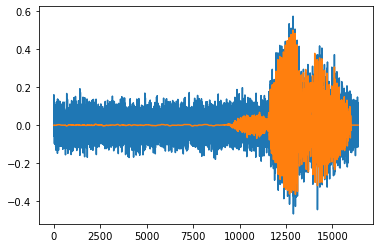

In [21]:
no = np.random.randint(BATCH_SIZE)
plt.plot(wav_batch[no].numpy())
plt.plot(wav_batch2[no].numpy())
plt.show()
ipd.display(ipd.Audio(wav_batch[no].numpy(), rate = 16000))
ipd.display(ipd.Audio(wav_batch2[no].numpy().flatten(), rate = 16000))

In [22]:
print("TRAINING SET")
#show_batch(wav_batch.numpy())

TRAINING SET


In [23]:
# Set up the validation data

val_pth = '/media/third/2020/datasets/sc09/sc09/valid/'
val_pth = '/media/third/2020/datasets/DEMAND/contrapt/test_clean_split/'
val_data_dir = pathlib.Path(val_pth)

In [24]:
image_count = len(list(val_data_dir.glob('*.wav')))
image_count

1647

In [25]:
list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/media/third/2020/datasets/DEMAND/contrapt/test_clean_split/p232_294_1.wav'
b'/media/third/2020/datasets/DEMAND/contrapt/test_clean_split/p232_170_0.wav'
b'/media/third/2020/datasets/DEMAND/contrapt/test_clean_split/p232_053_0.wav'
b'/media/third/2020/datasets/DEMAND/contrapt/test_clean_split/p257_347_2.wav'
b'/media/third/2020/datasets/DEMAND/contrapt/test_clean_split/p232_273_1.wav'


In [26]:
list_ds = tf.data.Dataset.list_files('/media/third/2020/datasets/DEMAND/contrapt/test_clean_split/*.wav')
#labeled_ds = list_ds.map(lambda x: tf.py_function(load_audio_file, [x], [tf.string])) # remove  [] and change estring to float

labeled_ds = list_ds.map(lambda x: tf.py_function(load_audio_file, [x], [tf.float32, tf.float32]))

In [27]:
for wav in labeled_ds.take(1):
    print("Image shape: ", wav[0].shape, wav[1].shape)
    #print("Label: ", label.numpy())

Image shape:  (16384,) (16384, 1)


In [28]:
validation_ds = prepare_for_training(labeled_ds, repeat = 1)

In [29]:
wav_batch = next(iter(validation_ds))

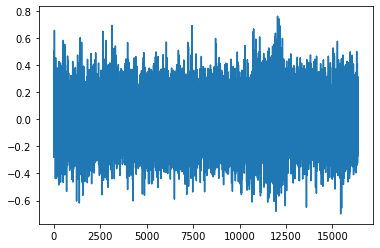

In [30]:
no = np.random.randint(BATCH_SIZE)
plt.plot(wav_batch[0][no].numpy())
plt.show()
ipd.display(ipd.Audio(wav_batch[0][no].numpy(), rate = 16000))

In [31]:
print("VALIDATION SET")
#show_batch(wav_batch[0].numpy())

VALIDATION SET


In [32]:
# NOW WE HAVE:

print(validation_ds)
print(train_ds)

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>


In [33]:
SAM_LENGTH = 16000
SAM_SHAPE = (SAM_LENGTH, 1)
print("BATCH_SIZE:",BATCH_SIZE)
print("STEPS_PER_EPOCH:",STEPS_PER_EPOCH)

BATCH_SIZE: 1
STEPS_PER_EPOCH: 28079.0


** Build the Generator:

The architecture of generator is a modified U-Net.

Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)

Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)

There are skip connections between the encoder and decoder (as in U-Net).

In [34]:
OUTPUT_CHANNELS = 1

In [35]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv1D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

(16384,)
(16384, 1)


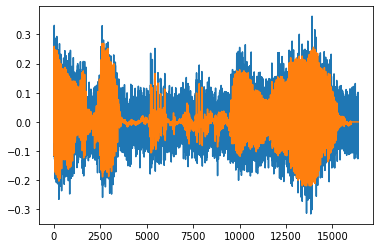

In [36]:
inp = wav[0]
plt.plot(inp)
plt.plot(wav[1])
print(inp.shape)
inp = tf.expand_dims(inp, 1)
print(inp.shape)

In [37]:
down_model = downsample(filters = 3, size = 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 8192, 3)


In [38]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv1DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [39]:
up_model = upsample(filters=1, size=4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 16384, 1)


In [40]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[16384, 1])

    down_stack = [
        downsample(64/2, 24, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128/2, 24), # (bs, 64, 64, 128)
        downsample(256/2, 24), # (bs, 32, 32, 256)
        downsample(512/2, 24), # (bs, 16, 16, 512)
        downsample(512/2, 24), # (bs, 8, 8, 512)
        downsample(512/2, 24), # (bs, 4, 4, 512)
        downsample(512/2, 24), # (bs, 2, 2, 512)
        downsample(512/2, 24), # (bs, 1, 1, 512)
        ]

    up_stack = [
        upsample(512/2, 24, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512/2, 24, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512/2, 24, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512/2, 24), # (bs, 16, 16, 1024)
        upsample(256/2, 24), # (bs, 32, 32, 512)
        upsample(128/2, 24), # (bs, 64, 64, 256)
        upsample(64/2, 24), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv1DTranspose(OUTPUT_CHANNELS, 24, #changed from 4
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

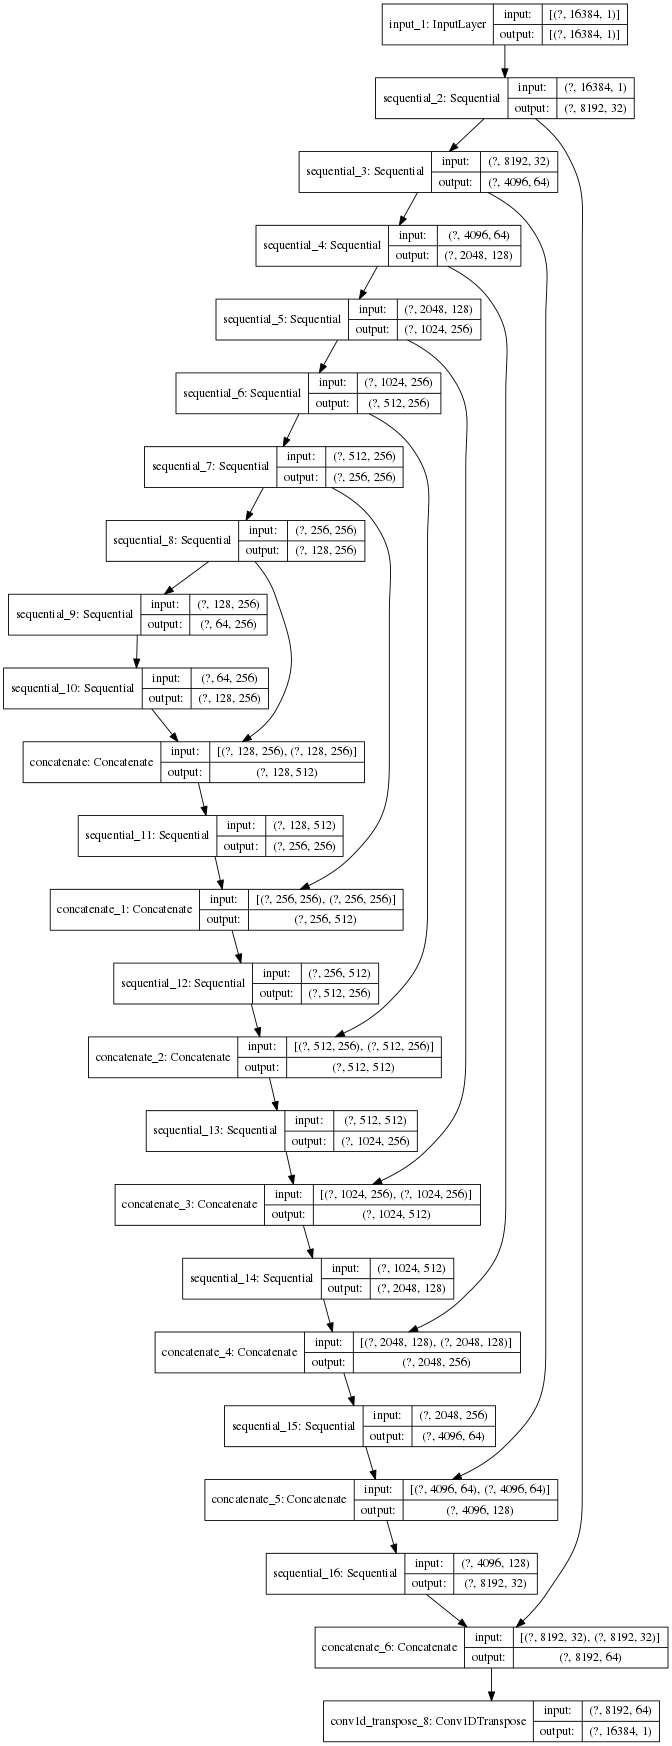

In [41]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

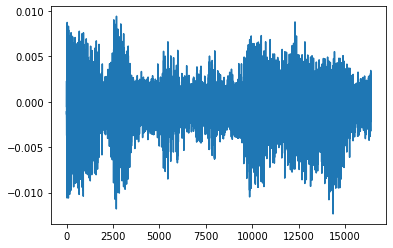

In [42]:
gen_output = generator(inp[tf.newaxis,...], training=False)
#plt.plot(inp)
plt.plot(gen_output[0,...])

In [43]:
LAMBDA = 100

In [44]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    #l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # Multi-scale spectrogram reconstruction loss.
    spectral_loss = ddsp.losses.SpectralLoss()
    l1_loss = spectral_loss(target, gen_output)  #not really l1_loss

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

Build the Discriminator

The Discriminator is a PatchGAN.

Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)

The shape of the output after the last layer is (batch_size, 30, 30, 1)

Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).

Discriminator receives 2 inputs.

Input image and the target image, which it should classify as real.

Input image and the generated image (output of generator), which it should classify as fake.

We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))

In [45]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[16384, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[16384, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64/2, 24, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128/2, 24)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256/2, 24)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding1D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv1D(512, 24, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding1D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv1D(1, 24, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

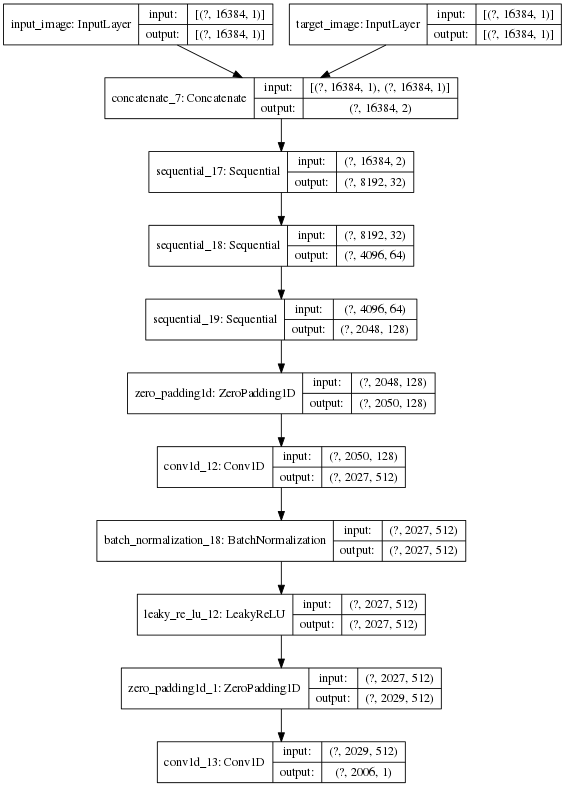

In [46]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

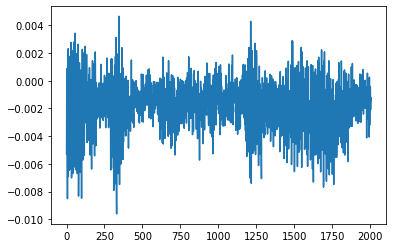

In [47]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.plot(disc_out[0,...,-1])
#plt.colorbar()

In [48]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [49]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [50]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [51]:
checkpoint_dir = './training_checkpoints_30'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [52]:
import soundfile as sf
from scipy.signal import minimum_phase
import pysptk
from sklearn.metrics import mean_squared_error
from math import sqrt
import pysepm



def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,7))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.plot(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
        ipd.display(ipd.Audio(display_list[i].numpy().flatten(), rate = 16000))
        
    plt.show()
    
    plt.figure(figsize=(15,7))
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        S = librosa.feature.melspectrogram(y=display_list[i].numpy().flatten(), sr=16000, n_mels=128,fmin = 0,
                                     fmax=8000, n_fft=728, hop_length=32, win_length = None, htk = True) # hop length lesser the better
        #plt.figure(figsize=(6,6)) 
        librosa.display.specshow(librosa.power_to_db(S ** 1.5, ref=np.max), fmin=0, y_axis='linear')# , cmap = 'gray')
        plt.axis('off')
            
    plt.show()
    
    
    clean_speech = tar[0].numpy().flatten() 
    noisy_speech = prediction[0].numpy().flatten() 
    
    print('------ Metrics ------')
    fs = 16000

    print("fwSNRseg",pysepm.fwSNRseg(clean_speech, noisy_speech, fs)) #fwSNRseg
    print("SNRseg",pysepm.SNRseg(clean_speech, noisy_speech, fs)) #SNRseg
    print("LLR",pysepm.llr(clean_speech, noisy_speech, fs)) #LLR
    print("STOI",pysepm.stoi(clean_speech, noisy_speech, fs)) # STOI
    print("PESQ",pysepm.pesq(clean_speech, noisy_speech, fs)) # PESQ

    print('*'*150)    
    

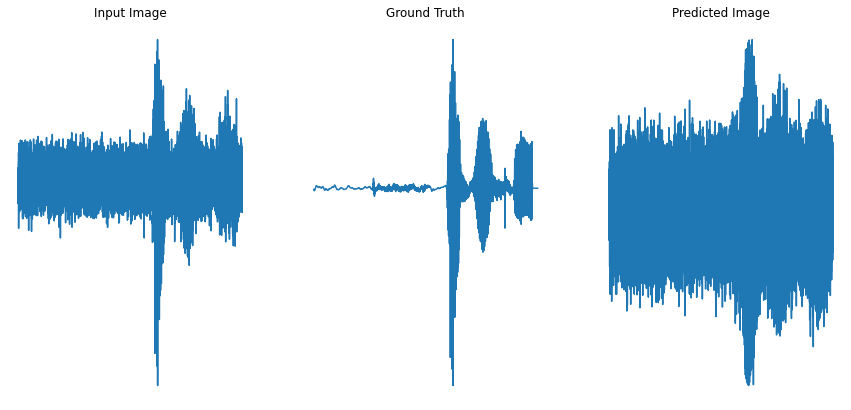

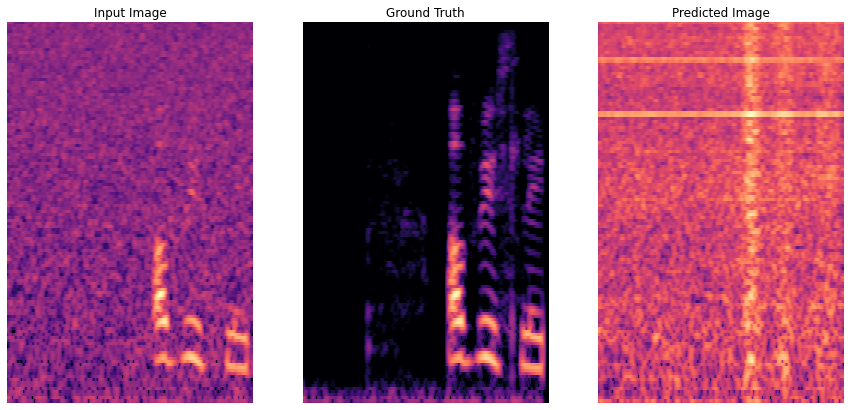

------ Metrics ------
fwSNRseg 2.036950687228641
SNRseg -10.0
LLR 1.91128755586723
STOI 0.6365324627019786
PESQ (nan, 1.0259112119674683)
******************************************************************************************************************************************************


In [53]:
for example_input, example_target in validation_ds.take(1):
    generate_images(generator, example_input, example_target)

In [54]:
EPOCHS = 150

In [55]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [56]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [57]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(5):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

In [58]:
'''checkpoint.restore('./training_checkpoints_30/ckpt-1')
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))'''

"checkpoint.restore('./training_checkpoints_30/ckpt-1')\ncheckpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))"

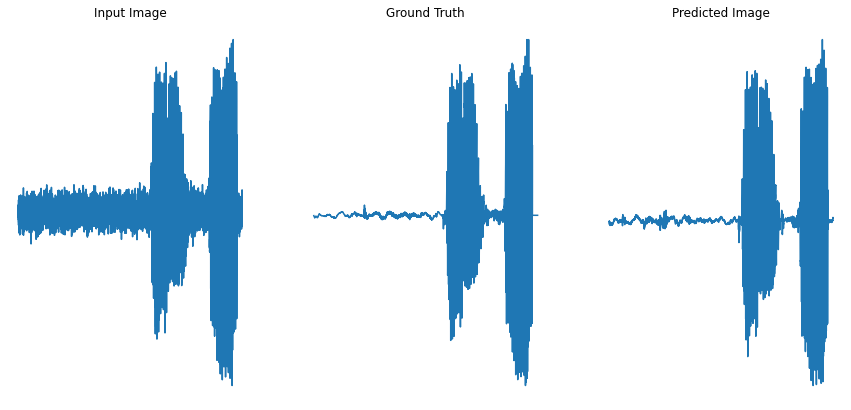

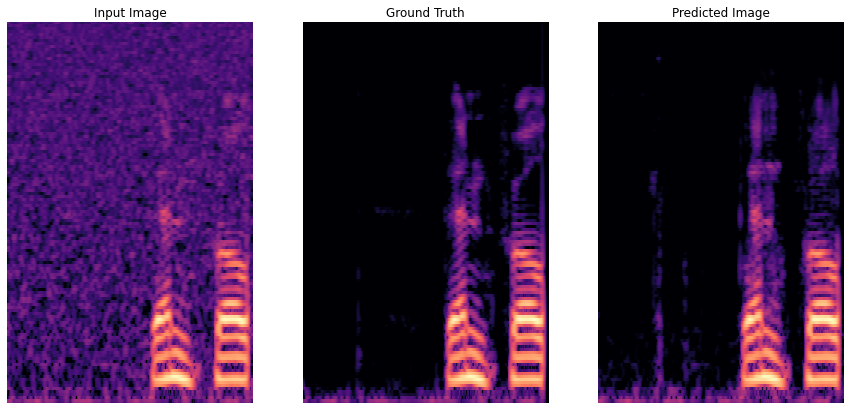

------ Metrics ------
fwSNRseg 8.673390846459109
SNRseg 6.422475799334836
LLR 1.1534890150754609
STOI 0.8173202660839539
PESQ (nan, 2.2507400512695312)
******************************************************************************************************************************************************


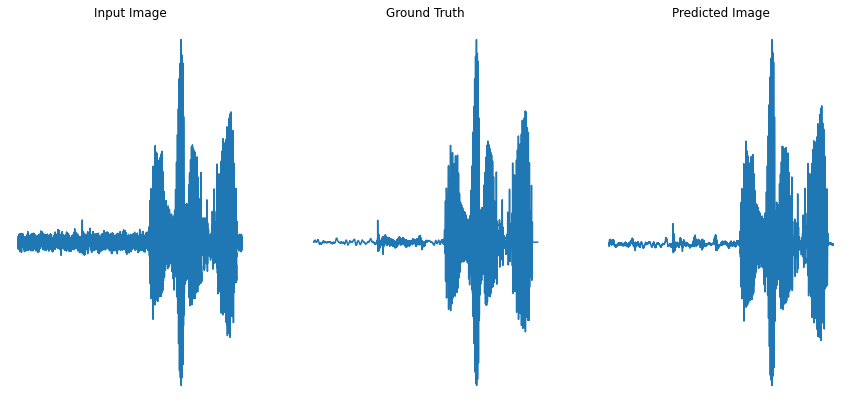

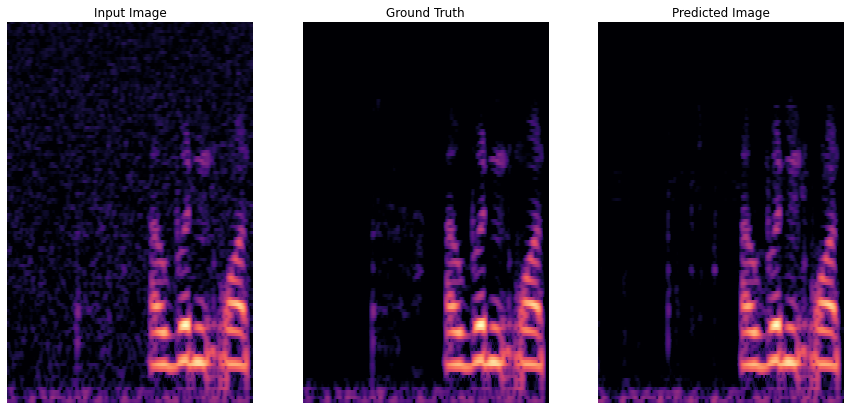

------ Metrics ------
fwSNRseg 9.26716297152345
SNRseg 8.574776994456556
LLR 1.0054546483852536
STOI 0.910722846531126
PESQ (nan, 2.2703611850738525)
******************************************************************************************************************************************************


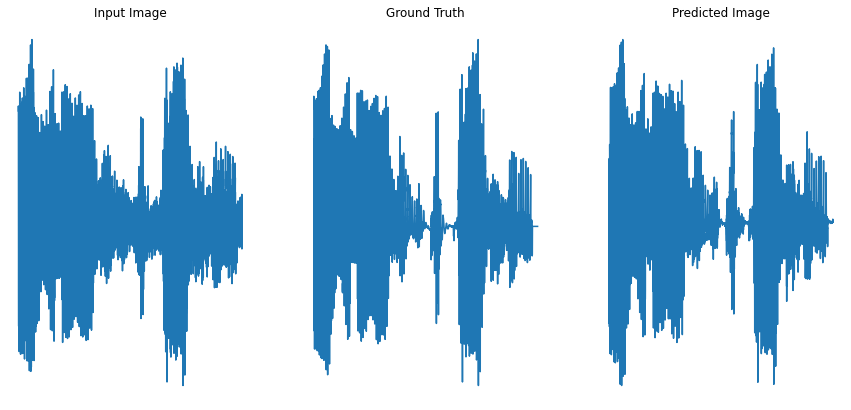

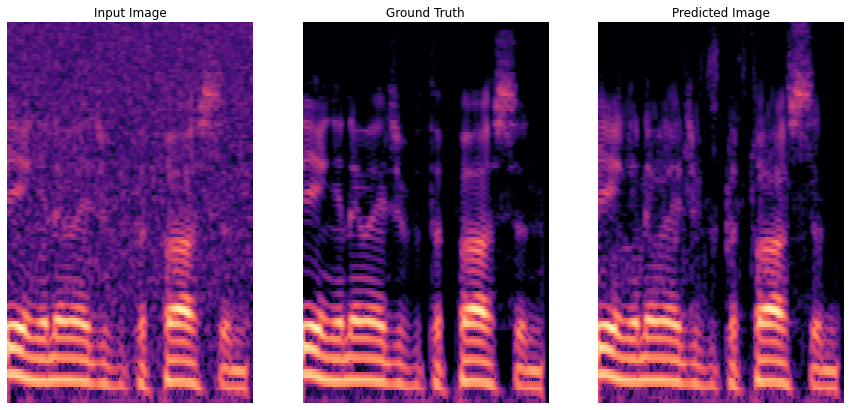

------ Metrics ------
fwSNRseg 13.981186546350019
SNRseg 12.396037980050227
LLR 0.9326919864838278
STOI 0.9358484360426469
PESQ (nan, 2.0186495780944824)
******************************************************************************************************************************************************


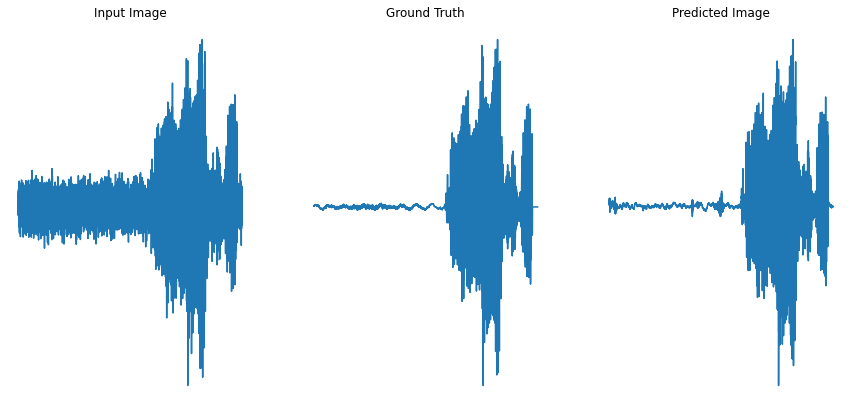

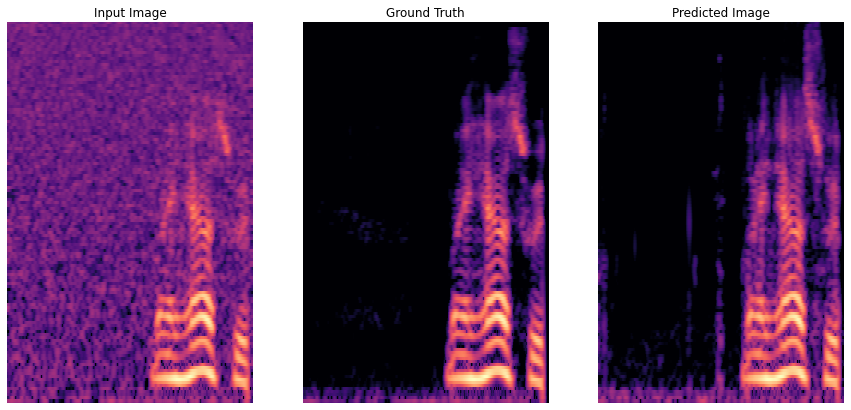

------ Metrics ------
fwSNRseg 7.352378763446332
SNRseg 3.090660219458442
LLR 1.186395676956047
STOI 0.6680116212467514
PESQ (nan, 1.8402490615844727)
******************************************************************************************************************************************************


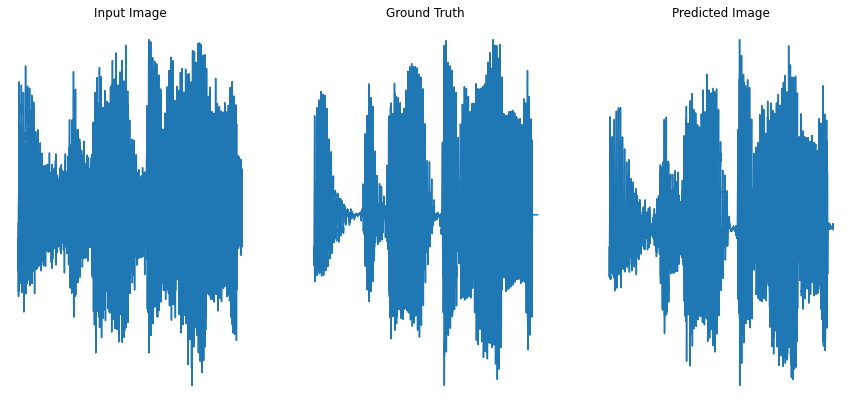

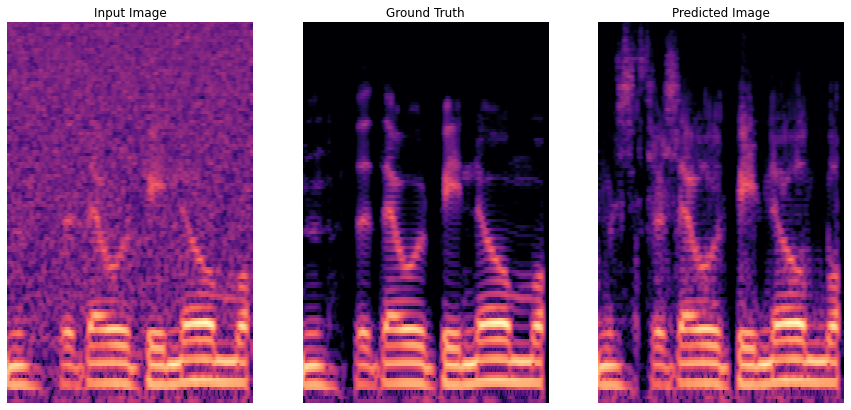

------ Metrics ------
fwSNRseg 10.740776250530406
SNRseg 9.970415677206995
LLR 1.309684206222856
STOI 0.9485438446310899
PESQ (nan, 1.4516410827636719)
******************************************************************************************************************************************************
Epoch:  4
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

In [ ]:
fit(train_dataset, EPOCHS, validation_ds)

In [ ]:
checkpoint.save(file_prefix = checkpoint_prefix)